## Real Data.

Columns:

1. Time: 		
        Seconds after midnight with decimal 
        precision of at least milliseconds 
        and up to nanoseconds depending on 
        the requested period
2. Type:
        1: Submission of a new limit order
        2: Cancellation (Partial deletion 
            of a limit order)
        3: Deletion (Total deletion of a limit order)
        4: Execution of a visible limit order			   	 
        5: Execution of a hidden limit order
        7: Trading halt indicator 				   
        We only care about 4 and 5 as they mean that a trade has happened.
3. Order ID: 	
        Unique order reference number 
        (Assigned in order flow)
4. Size: 		
        Number of shares
5. Price: 		
        Dollar price times 10000 , A stock price of \$ 91.14 is given by 911400,  tick size \$ 0.01 > 100 on the table
6. Direction:
        -1: Sell limit order
        1: Buy limit order
        Note: 
        Execution of a sell (buy) limit
        order corresponds to a buyer (seller) 
        initiated trade, i.e. Buy (Sell) trade.

We have considered 5 stockes ( AAPL,GOOG,MSFT, AMZN, INTC) on the same day.2012-06-21. 


In [198]:
import pandas as pd 
import numpy as np 
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm
from collections import defaultdict


So we will work on "the last traded price" , using lobsterdata. (Similar to LOB docs we have seen on Price Impact)

In [199]:
files = ['GOOG.csv','INTC.csv','AAPL.csv','AMZN.csv','MSFT.csv']
s = files[-3]
data = pd.read_csv(s) #just change the name of the file.

data.columns = ['time','type','Order ID', 'Size','Price','Direction']
last_price = data.loc[ (data.type == 4) | (data.type == 5)   , ['time','Price','Size','type','Direction']]
#types : 4: Execution of a visible limit order , 5: Execution of a hidden limit order
#last_price = last_price.loc[:,:]
last_price.reset_index(drop=True,inplace =True) 
last_price,s

(               time    Price  Size  type  Direction
 0      34200.275016  5857400    40     4         -1
 1      34200.275016  5857500    25     4         -1
 2      34200.275057  5857300     1     4          1
 3      34200.275063  5857300    10     4          1
 4      34200.275072  5857500    25     4         -1
 ...             ...      ...   ...   ...        ...
 34985  57599.355373  5775500    89     4          1
 34986  57599.444020  5776000   103     4          1
 34987  57599.444020  5776000    11     4          1
 34988  57599.913118  5776100    48     4         -1
 34989  57599.913118  5776350    52     5         -1
 
 [34990 rows x 5 columns],
 'AAPL.csv')

( tick =  $0.01, so it is a value of 100 on the table, but hidden orders have jumps of half a tick size)

In [200]:
for i in range(1,len(last_price)-1):
    if (last_price.iat[i+1,1] - last_price.iat[i,1])%100 != 0:
        if (last_price.iat[i+1,1] - last_price.iat[i,1]) < 0:
            last_price.iat[i+1,1] -=50
        else:
            last_price.iat[i+1,1] +=50


we take only the events where the price has changed

In [201]:
last_price["price_change"]= last_price['Price'].diff(1)
final_data= last_price.loc[last_price['price_change']!=0,['time','Price','Size','type','Direction']] 
final_data["price_change"]= last_price['Price'].diff(1)
final_data.iat[0,-1] =0

final_data.set_index(pd.Index(range(len(final_data))), inplace=True)


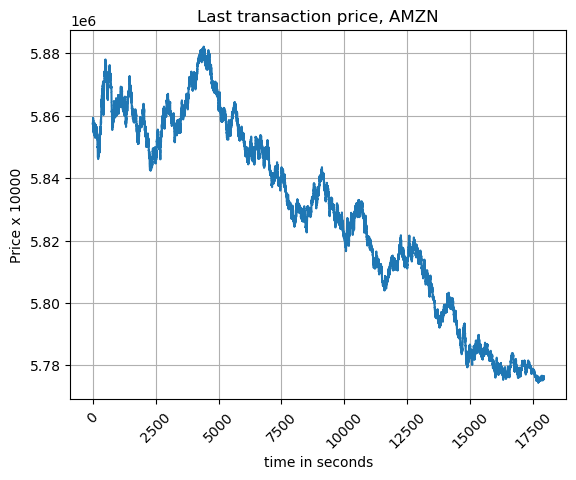

In [202]:
plt.step(final_data.index - final_data.index[0], final_data['Price'], where='post')
plt.xlabel('time in seconds')
plt.ylabel('Price x 10000')
plt.title('Last transaction price, AMZN')


plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('AMZN.pdf')

plt.show()


# estimation of   $\eta$ :
Let $N_{\alpha,t} = card\{t_i, t_i<t \}$,
we define the following quantities , for k =  1 , ... , m :
$$ N^{(c)}_{\alpha,t,k} = \sum ^{N_{\alpha,t}}   \mathbb{1}_{\{ | X_{\tau_{i+1}} - X_{\tau_i}| = \alpha k\}} $$
$$ N^{(a)}_{\alpha,t,k} = \sum ^{N_{\alpha,t}}  \mathbb{1}_{\{ | X_{\tau_{i+1}} - X_{\tau_i}| = \alpha (k-1+2\eta)\}} $$

then 
$$ \hat{\eta}_t = \sum ^{m} \lambda_{\alpha,t,k}. \mu_{\alpha,t,k}$$

where :

$$ \lambda_{\alpha,t,k} = \frac{N^{(a)}_{\alpha,t,k} + N^{(c)}_{\alpha,t,k}}{ \sum_i N^{(a)}_{\alpha,t,i} + N^{(c)}_{\alpha,t,i}} $$
and 

$$
\mu_{\alpha,t,k} = \frac{1}{2}(k(\frac{N^{(c)}_{\alpha,t,k}}{N^{(a)}_{\alpha,t,k}}-1)+1).
$$

In [203]:
np.abs(final_data['price_change']).describe()

count    17925.000000
mean       332.184100
std        340.739953
min          0.000000
25%        100.000000
50%        200.000000
75%        400.000000
max       7100.000000
Name: price_change, dtype: float64

<Axes: >

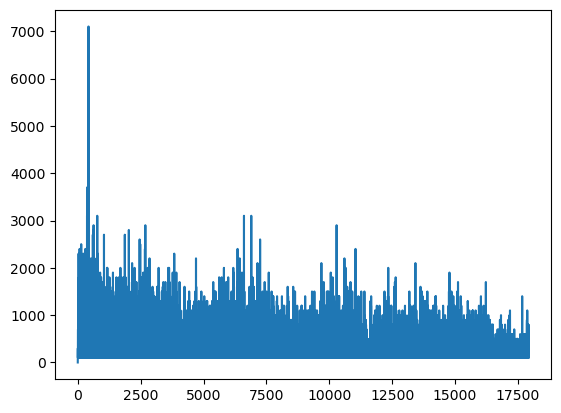

In [204]:
np.abs(final_data['price_change']).plot()
#we can see that the price_change depends on the value of eta. 

In [205]:
def eta(data):
    continuations = defaultdict(int)
    alternations = defaultdict(int)
    for i in range(1,len(data)-1):
        if data.iat[i,-1]*data.iat[i+1,-1] > 0 :
            continuations[ np.abs(data.iat[i+1,-1])/100]+=1
        else:
            alternations[np.abs(data.iat[i+1,-1])/100 ]+=1
            
    lamda = defaultdict(int)
    mu = defaultdict(int)
    som = 0
    total = len(data)-2 #as we do not include the first and the last price changes.
    for el in alternations.keys():
        lamda[el] = (alternations[el] + continuations[el])/total
        mu[el] = 0.5 * ( el*((continuations[el]/alternations[el]) - 1) + 1)    
        som += mu[el]*lamda[el]    
    return som
x_values = []
y_values = []

for t in range(1000,len(final_data),1000):
    print(t)
    x_values.append(t)
    y_values.append(eta(final_data.loc[t-1000:t,:]))

# Plot the data
#plt.plot(x_values, y_values, marker='o', linestyle='-')


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [206]:
np.mean(y_values)

0.8802885052312182

<Axes: >

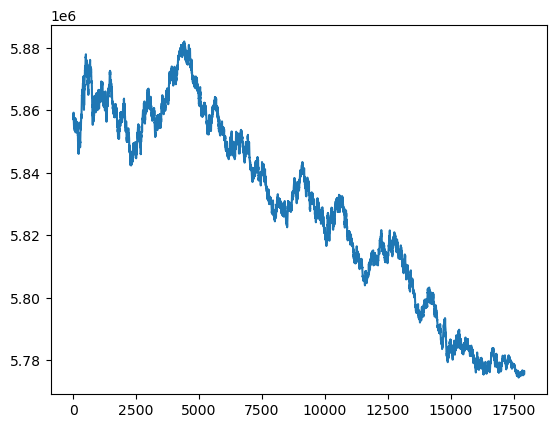

In [207]:
final_data.loc[:,'Price'].plot()

# Efficient Price estimate and $ \sigma$

$$
X_{\tau_i} = P_{t_i} - \alpha(\frac{1}{2}- \hat{\eta}) sign(P_{t_i}-P_{t_i})
$$

At some indexs, the same "order" can be decomposed into multiple orders since since the size of the total orders excedes the size of the best limit order ( can be seen as some Price impact). So We take only the last one traded.

In [208]:
eta_estimate = eta(final_data)
eta_estimate

0.7379291476227274

In [209]:
final_data['eff price'] =  final_data.loc[:,"Price"].values - 100*(1/2 - eta_estimate)*np.sign(final_data['price_change'])

In [210]:
def log_quadratic_variation(series):
    log_series = np.log(series)  # Compute the logarithm of the series
    log_diff = np.diff(log_series)  # Calculate the difference between consecutive logarithmic values
    quad_var = np.sum(log_diff ** 2)  # Calculate the sum of squared differences
    return quad_var

# Example usage
result = log_quadratic_variation(final_data['eff price'].values)
print("volatility squared :", result)

volatility squared : 0.00012845071822863242


## Hedging Error.

1.  $\hat{L}^{(1)} = (X_T - K)^{+} - C(0,X_0)-\sum\limits_{i=0}^{n-1} \Delta_{\text{estimated}}(t_i)(X_{t_{i+1}} - X_{t_i})$

2.   $\hat{L}^{(2)} =  (X_T - K)^{+} - C(0,X_0) - \sum\limits_{i=0}^{n-1}\Delta_{\text{estimated}}(t_i)(P_{t_{i+1}} - P_{t_i})$

We will compute the hedging error for different values of the strike.

In [211]:
K =final_data['eff price'].min()
vol = np.sqrt(log_quadratic_variation(final_data['eff price'].values))
T = 1 
l_i = 500 #that is for the third hedging strategy


def option_price(S,K,mat,sigma):
    d1 = (np.log(S / K) + (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))
    d2 = (np.log(S / K) - (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))
    return (S*norm.cdf(d1) - K * norm.cdf(d2))
def delta_hedging(S, K, mat, sigma):
    d1 = (np.log(S / K) + (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))
    return norm.cdf(d1)
    


We standardize time so that each day is represented on a scale from 0 to 1. Another challenge arises when we receive multiple orders at specific times, each with varying execution prices. This phenomenon suggests that certain orders, particularly larger ones, may cause price impact by depleting liquidity from the order book. Consequently, a single "big" order can essentially be viewed as comprising multiple simultaneous orders with different execution prices. In such cases, we will consider the latest traded price at each moment. Someone seeking to hedge will only be able to do so once all orders have been executed

In [212]:
final_data['time'] = (final_data['time'] - final_data.iloc[0,0])/(final_data.iloc[-1,0] - final_data.iloc[0,0]) 
final_data = final_data.groupby('time').tail(1)
final_data.reset_index(drop=True, inplace=True)
final_data


,time,Price,Size,type,Direction,price_change,eff price
0,0.000000e+00,5857500,25,4,-1,100.0,5.857524e+06
1,1.766480e-09,5857300,1,4,1,-200.0,5.857276e+06
2,2.407388e-09,5859300,37,4,-1,100.0,5.859324e+06
3,6.099696e-06,5857200,23,5,1,-100.0,5.857176e+06
4,6.150854e-06,5857000,23,4,1,-200.0,5.856976e+06
...,...,...,...,...,...,...,...
15592,9.999653e-01,5775900,100,5,1,-700.0,5.775876e+06
15593,9.999663e-01,5775800,100,4,1,-100.0,5.775776e+06
15594,9.999705e-01,5775500,256,4,1,-300.0,5.775476e+06
15595,9.999800e-01,5776000,103,4,1,500.0,5.776024e+06


In [213]:
def find_threshold_indices(df, threshold):
    indices = [0]  # Initialize with the first index
    previous_price = df.iloc[0]['Price']  # Get the price at the first index
    for i in range(1, len(df)):
        current_price = df.iloc[i]['Price']
        if np.abs(current_price - previous_price) > threshold:
            indices.append(i)
            previous_price = current_price
    return indices

indexs_for_l3 = find_threshold_indices(final_data, l_i)
final_data_l3 = final_data.loc[indexs_for_l3,:]
sum(np.abs(final_data_l3.Price.diff(1))>=500)

4679

In [214]:
Delta = delta_hedging(final_data['eff price'], K, 1 - final_data['time'] , 0.0013)
Delta_L3 = delta_hedging(final_data_l3['eff price'], K, 1 - final_data_l3['time'] , 0.0013)

In [215]:
l = option_price(final_data['eff price'],K,1 - final_data['time'],0.0013) 
l = (l - l[0])#/final_data["eff price"].mean()


In [216]:
hedge2 = np.cumsum( (Delta[:-1] * final_data['Price'].diff(1)[1:])) #/final_data['eff price'].mean()
hedge1 = np.cumsum( (Delta[:-1] * final_data['eff price'].diff(1)[1:])) #/final_data['eff price'].mean()
hedge3 = np.cumsum( (Delta_L3[:-1] * final_data_l3['Price'].diff(1)[1:]))

<Figure size 640x480 with 0 Axes>

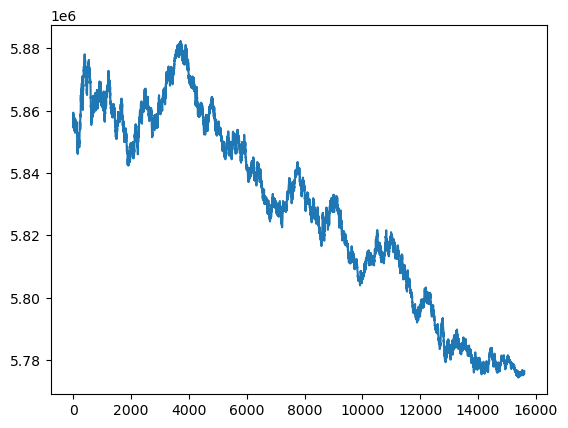

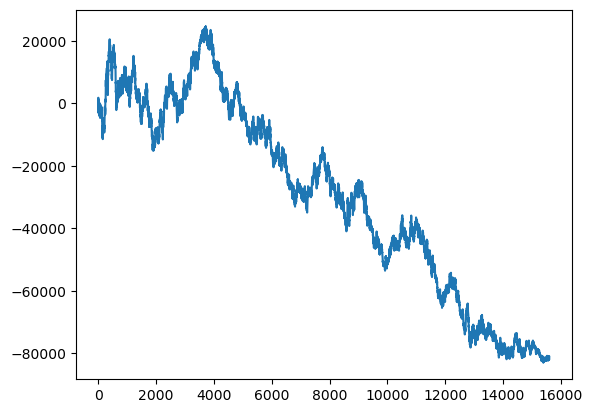

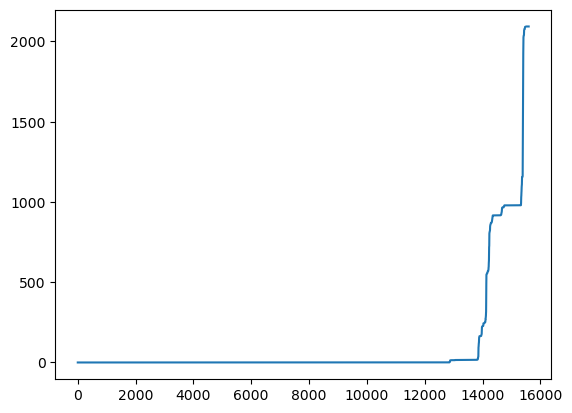

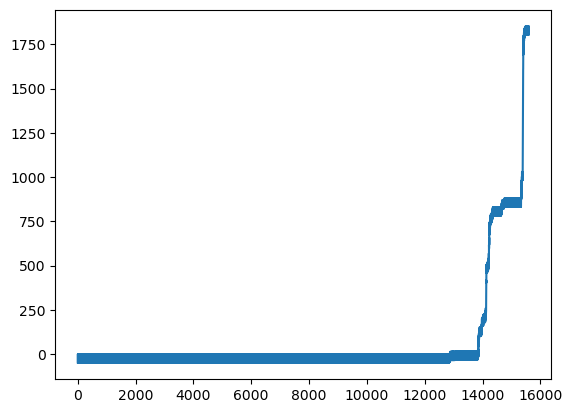

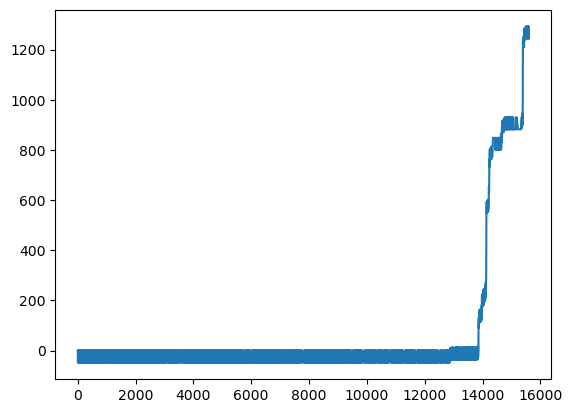

<Figure size 640x480 with 0 Axes>

In [217]:
final_data['eff price'].plot()
plt.figure()
l.plot()
plt.figure()
(l - hedge1).plot()
plt.figure()
(l - hedge2).plot()
plt.figure()
(l.loc[indexs_for_l3] - hedge3).plot()
plt.figure()